In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import export_graphviz, plot_tree
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances
from treeinterpreter import treeinterpreter
# from fastai.tabular import *
sns.set()

d:\hust\support_system\project\dss\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
d:\hust\support_system\project\dss\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
d:\hust\support_system\project\dss\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module i

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [3]:
df_raw = pd.read_csv('churn.csv')


In [4]:
display_all(df_raw.head())

NameError: name 'display_all' is not defined

In [5]:
y = df_raw['churn']
df = df_raw.drop(['churn', 'phone_number'], axis=1)

In [6]:
class DFProc():
    def __call__(self, df, test=False):
        func = self.apply_test if test else self.apply_train
        return func(df)
    def apply_train(self, df):
        raise NotImplementedError
    def apply_test(self, df):
        self.apply_train(df)
        
class ProcCategory(DFProc):
    def __init__(self, cat_names):
        self.cat_names = cat_names
        self.categories = {}
        
    def apply_train(self, df):
        for i in self.cat_names:
            df.loc[:, i] = df.loc[:, i].astype('category').cat.as_ordered()
            self.categories[i] = df.loc[:, i].cat.categories
            df[i] = df[i].cat.codes
        return df   
    def apply_test(self, df):
        for i in self.cat_names:
            df[i] = pd.Categorical(df[i], categories=self.categories[i])
            df[i] = df[i].cat.codes
        return df
    
class Normalize(DFProc):
    def __init__(self, cont_vars):
        self.cont_vars = cont_vars
        self.means = {}
        self.stds = {}
    
    def apply_train(self, df):
        for c in self.cont_vars:
            self.means[c] = df.loc[:, c].mean()
            self.stds[c] = df.loc[:, c].std()
            df.loc[:, c] = (df.loc[:, c] - self.means[c]) / (1e-7 + self.stds[c])
        return df
    
    def apply_test(self, df):
        for c in self.cont_vars:
            df.loc[:, c] = (df.loc[:, c] - self.means[c]) / (1e-7 + self.stds[c])
        return df

In [10]:
df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + df['total_intl_charge']

In [127]:
df['many service call'] = df['customer service calls'] >= 4

In [128]:
df['charge_min_ratio'] = df['total charge'] / (df['total day minutes'] + df['total eve minutes'] + df['total night minutes'] + df['total intl minutes'])

In [91]:
cat_var = ['state', 'area code', 'international plan', 'voice mail plan', 'many service call']
num_var = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge',
           'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls',
           'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls',
           'total charge']

In [92]:
proc = ProcCategory(cat_var)
df = proc(df)

In [4]:
display_all(df.head())

NameError: name 'display_all' is not defined

In [94]:
train_idx = np.load('train_idx.npy')
valid_idx = np.load('valid_idx.npy')

In [95]:
def print_score(m):
    y_train_pred = m.predict(X_train)
    y_valid_pred = m.predict(X_valid)
    print('Train accuracy ', m.score(X_train, y_train))
    print('Train precision ', precision_score(y_train, y_train_pred))
    print('Train recall ', recall_score(y_train, y_train_pred))
    print('Train f1 score ', f1_score(y_train, y_train_pred))
    print('Validation accuracy ', m.score(X_valid, y_valid))
    print('Validation precision ', precision_score(y_valid, y_valid_pred))
    print('validation recall ', recall_score(y_valid, y_valid_pred))
    print('Validation f1 score ', f1_score(y_valid, y_valid_pred))
    if hasattr(m, 'oob_score_'): print('oob score ', m.oob_score_)

In [96]:
X_train, X_valid, y_train, y_valid = df.iloc[train_idx], df.iloc[valid_idx], y[train_idx], y[valid_idx]

In [99]:
rf = RandomForestClassifier(1000, criterion='entropy', min_samples_leaf=5, max_features=0.6,
                             n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=0.6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [100]:
print_score(rf)

Train accuracy  0.9769484083424808
Train precision  1.0
Train recall  0.8409090909090909
Train f1 score  0.9135802469135803
Validation accuracy  0.9816666666666667
Validation precision  1.0
validation recall  0.8735632183908046
Validation f1 score  0.9325153374233129
oob score  0.9762166117819246


In [101]:
def plot_imp(imp): 
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(imp['Feature'], imp['Importance'])

In [102]:
per_imp = PermutationImportance(rf).fit(X_valid, y_valid)

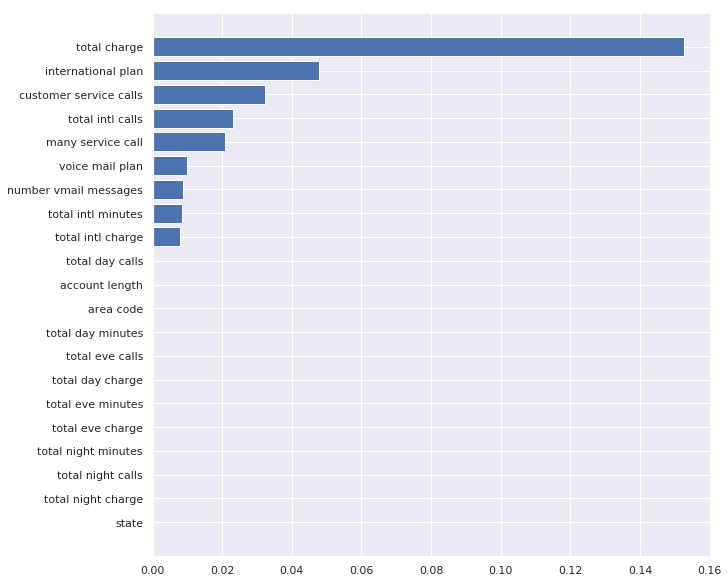

In [103]:
per_imp = pd.DataFrame({'Feature': df.columns, 'Importance': per_imp.feature_importances_}).sort_values('Importance')
plot_imp(per_imp)

In [105]:
keep = per_imp[per_imp['Importance'] > 0].Feature
keep

17         total intl charge
15        total intl minutes
5      number vmail messages
4            voice mail plan
20         many service call
16          total intl calls
18    customer service calls
3         international plan
19              total charge
Name: Feature, dtype: object

In [106]:
X_train = X_train[keep]
X_valid = X_valid[keep]

In [113]:
rf = RandomForestClassifier(1000, criterion='entropy', min_samples_leaf=2, max_features=0.5,
                             n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print_score(rf)

Train accuracy  0.9787778997438712
Train precision  1.0
Train recall  0.8535353535353535
Train f1 score  0.9209809264305178
Validation accuracy  0.9833333333333333
Validation precision  1.0
validation recall  0.8850574712643678
Validation f1 score  0.9390243902439025
oob score  0.9762166117819246


In [130]:
df_raw['total charge'] = df['total charge']

In [138]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


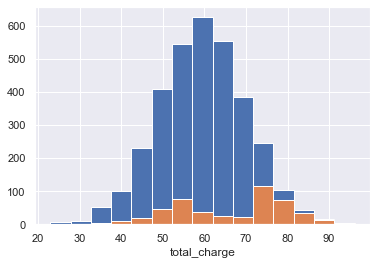

In [12]:
tips = sns.load_dataset("tips") 
sns.distplot(df['total_charge'], kde=False, hist_kws={"alpha": 1}, bins=15) 
sns.distplot(df[df_raw.churn == True]['total_charge'], kde=False, hist_kws={"alpha":1}, bins=15) 
plt.show()

/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


([array([0.000604, 0.001056, 0.003698, 0.007169, 0.015017, 0.022487, 0.036372, 0.036749, 0.038409, 0.028222, 0.015922,
         0.006716, 0.002037, 0.000604, 0.      ]),
  array([0.000679, 0.001132, 0.004301, 0.008225, 0.016903, 0.026185, 0.040598, 0.040145, 0.040749, 0.032071, 0.020525,
         0.012149, 0.005207, 0.001962, 0.000679])],
 array([ 0.   ,  3.976,  7.952, 11.928, 15.904, 19.88 , 23.856, 27.832, 31.808, 35.784, 39.76 , 43.736, 47.712, 51.688,
        55.664, 59.64 ]),
 <a list of 2 Lists of Patches objects>)

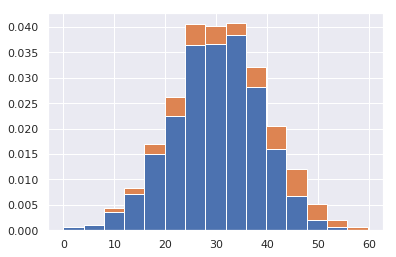

In [9]:
fig, ax = plt.subplots()
ax.hist([df_raw[df_raw['churn']==0]['total day charge'],
         df_raw[df_raw['churn']==1]['total day charge']],
         bins=15, stacked=True, label=[False, True], ne)